# Train Accident Analysis and Data Exploration using Apache Spark

This notebook is the [assignment](https://console.ng.bluemix.net/data/notebooks/fadb25c7-8554-4ceb-a4f6-7150f1986db7/view?access_token=dcbb44ae304e451cdad622dd46dd42e099d81538ac9250e08a59d69be75d6c68) done by Team 6 for CMPE272 at SJSU. It shows you how to analyze railway accidents using data from [trainwreckdb](http://www.trainwreckdb.com). The data range from January to April, 2016. We use Python as our language and we analyized this data in four perspectives:

* Fistly, we evaluated what are the top 10 cities and railroad having the most vehicle accidents.
* Next, we search the cases which pedestrians were involved.
* Then we found out which top 10 railway companies were involved in those accidents. 
* Finally, we divided those accidents into daily hours and investigate to see when do the accident more like to happen.

## Importing Data

The data was originally download as csv file. We upload to Object Storage in IBM bluemix so it can be used through Apache Spark. Also we briefly inspect rows and columns of the data.

In [1]:
credentials = {
  'auth_url':'https://identity.open.softlayer.com',
  'project':'object_storage_c67bbb5b_5b85_42fc_b4fe_818070c55db7',
  'project_id':'b72aa02b17714f338be87b13934093cc',
  'region':'dallas',
  'user_id':'8b0d9461a687486089854fea4c0a1a88',
  'domain_id':'d84e3e35da554e32b4d0b8ce8334e6b8',
  'domain_name':'1141541',
  'username':'admin_8d2e1a30789bd861f5f7f5b1e338aff014d6d4ae',
  'password':"""TnxytWnjN3b9,N6)""",
  'filename':'traindb_new.csv',
  'container':'notebooks',
  'tenantId':'s842-b4a0e8a248ecef-de62ffe0452b'
}

In [2]:
def set_hadoop_config(credentials):
    prefix = "fs.swift.service." + credentials['name'] 
    hconf = sc._jsc.hadoopConfiguration()
    hconf.set(prefix + ".auth.url", credentials['auth_url']+'/v3/auth/tokens')
    hconf.set(prefix + ".auth.endpoint.prefix", "endpoints")
    hconf.set(prefix + ".tenant", credentials['project_id'])
    hconf.set(prefix + ".username", credentials['user_id'])
    hconf.set(prefix + ".password", credentials['password'])
    hconf.setInt(prefix + ".http.port", 8080)
    hconf.set(prefix + ".region", credentials['region'])
    hconf.setBoolean(prefix + ".public", True)

In [3]:
credentials['name'] = 'keystone'
set_hadoop_config(credentials)

In [4]:
test = sc.textFile("swift://notebooks.keystone/traindb_new.csv")

In [169]:
from __future__ import division
import numpy as np

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

# adding the PySpark modul to SparkContext
sc.addPyFile("https://raw.githubusercontent.com/seahboonsiew/pyspark-csv/master/pyspark_csv.py")
import pyspark_csv as pycsv

def skip_header(idx, iterator):
    if (idx == 0):
        next(iterator)
    return iterator

test_header = test.first()

test_header_list = test_header.split(",")
test_body = test.mapPartitionsWithIndex(skip_header)

# filter not valid rows
test_body = test_body.filter(lambda line : line.split(","))

# create Spark DataFrame using pyspark-csv
test_df = pycsv.csvToDataFrame(sqlContext, test_body, sep=",", columns=test_header_list)
test_df.cache()

DataFrame[Date: timestamp, City/State: string, Street: string, Railroad: string, Description: string]

In [170]:
test_df.first()

Row(Date=datetime.datetime(2016, 4, 30, 17, 45), City/State=u'CROWLEY, LOUISIANA', Street=u'SIDNEY RICHARD ROAD', Railroad=u'Union Pacific Railroad Company', Description=u'PICKUP TRUCK STOPPED TOO CLOSE TO THE TRACKS AND WAS STRUCK BY THE ONCOMING TRAIN. #32 WARNING DEVICES: YIELD SIGN')

In [171]:
test_df

DataFrame[Date: timestamp, City/State: string, Street: string, Railroad: string, Description: string]

In [172]:
test_df.registerTempTable("test")
sqlContext.cacheTable("test")

## Top 10 City/State with the most accidents involving vehicles

In [173]:
test_sql = sqlContext.sql("SELECt * FROM test WHERE Description LIKE '%VEHICLE%'").collect()

In [191]:
!pip install --user seaborn

%matplotlib inline

import matplotlib.pyplot as plt
# matplotlib.patches allows us create colored patches, we can use for legends in plots
import matplotlib.patches as mpatches
# seaborn also builds on matplotlib and adds graphical features and new plot types
import seaborn as sns
import pandas as pd

In [192]:
from pyspark.sql import functions as F

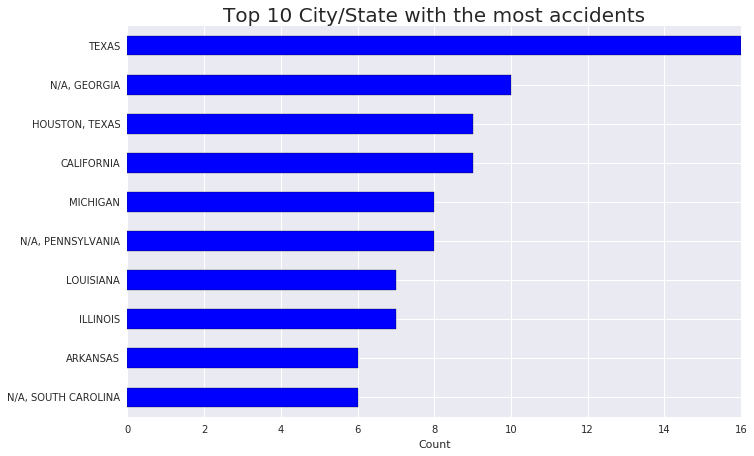

In [193]:
plottingdf = test_df.groupBy("City/State").agg(F.count("City/State").alias("sum(accidents)")).\
sort(F.desc('sum(accidents)')).limit(10).toPandas() 
plottingdf[['sum(accidents)']].plot(kind='barh', figsize=(11,7), legend=False) 
plt.title('Top 10 City/State with the most accidents involving Vehicles', size=20) 
plt.xlabel('Count') 
plt.yticks(range(10), 
plottingdf['City/State']) 
plt.gca().invert_yaxis() 
plt.show()

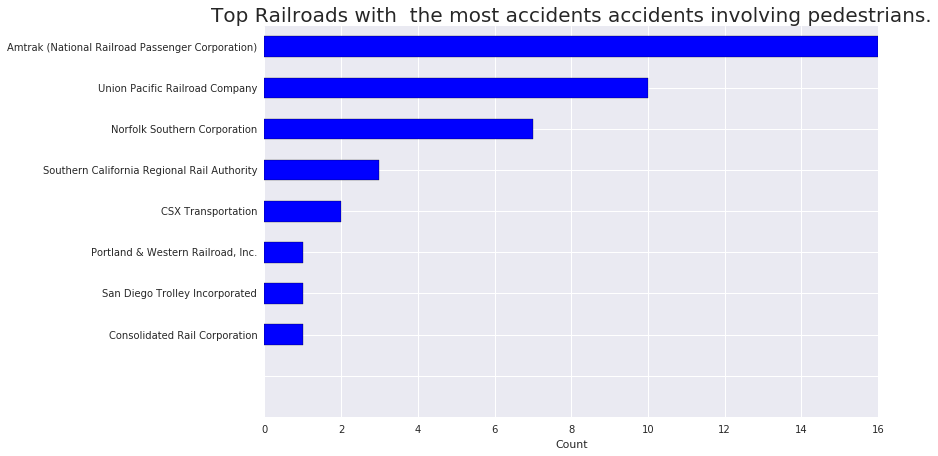

In [187]:
plottingdf = test_sql.groupBy("Railroad").agg(F.count("Railroad").alias("sum(accidents)")).\
sort(F.desc('sum(accidents)')).limit(10).toPandas() 
plottingdf[['sum(accidents)']].plot(kind='barh', figsize=(11,7), legend=False) 
plt.title('Top Railroads with  the most accidents accidents involving vehicles', size=20) 
plt.xlabel('Count') 
plt.yticks(range(10), 
plottingdf['Railroad']) 
plt.gca().invert_yaxis() 
plt.show()

## Top City/State and Railroad with  the most accidents accidents involving pedestrians

In [185]:
test_sql = sqlContext.sql("SELECt * FROM test WHERE Description LIKE '%PEDESTRIAN%'")

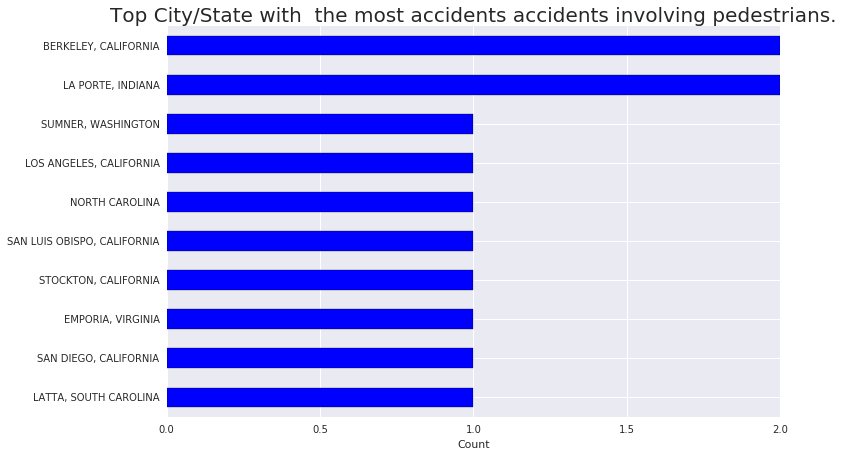

In [186]:
plottingdf = test_sql.groupBy("City/State").agg(F.count("City/State").alias("sum(accidents)")).\
sort(F.desc('sum(accidents)')).limit(10).toPandas() 
plottingdf[['sum(accidents)']].plot(kind='barh', figsize=(11,7), legend=False) 
plt.title('Top City/State with  the most accidents accidents involving pedestrians', size=20) 
plt.xlabel('Count') 
plt.yticks(range(10), 
plottingdf['City/State']) 
plt.gca().invert_yaxis() 
plt.show()

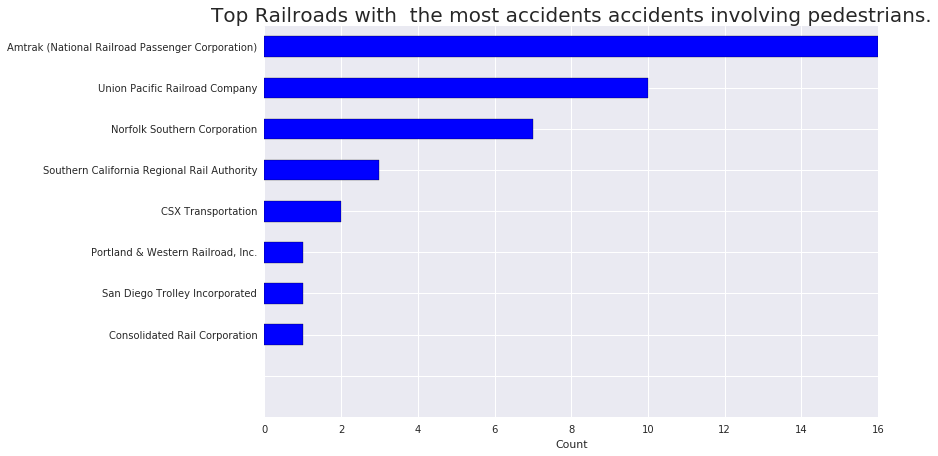

In [187]:
plottingdf = test_sql.groupBy("Railroad").agg(F.count("Railroad").alias("sum(accidents)")).\
sort(F.desc('sum(accidents)')).limit(10).toPandas() 
plottingdf[['sum(accidents)']].plot(kind='barh', figsize=(11,7), legend=False) 
plt.title('Top Railroads with  the most accidents accidents involving pedestrians.', size=20) 
plt.xlabel('Count') 
plt.yticks(range(10), 
plottingdf['Railroad']) 
plt.gca().invert_yaxis() 
plt.show()

## Top 10 Railroads with Most Accidents

In [178]:
railroad_accidents = sqlContext.sql("SELECT Railroad, COUNT(*) AS Accidents FROM test GROUP BY Railroad ORDER BY Accidents DESC LIMIT 10").collect()

In [179]:
railroads = [0] * 10
index = 0
for row in railroad_accidents:
    railroads[index]=row.Railroad
    index = index + 1
    
print railroads

[u'Union Pacific Railroad Company', u'Norfolk Southern Corporation', u'CSX Transportation', u'BNSF Railway Company', u'Amtrak (National Railroad Passenger Corporation)', u'Kansas City Southern Railway Company', u'Wisconsin Central Ltd. (also Railway)', u'Canadian Pacific Railway Company', u'Southern California Regional Rail Authority', u'South Florida Regional Transit Authority']


In [180]:
accidents = [0] * 10
index = 0
for row in railroad_accidents:
    accidents[index]=row.Accidents
    index = index + 1
    
print accidents

[114, 99, 99, 68, 52, 18, 13, 9, 8, 7]


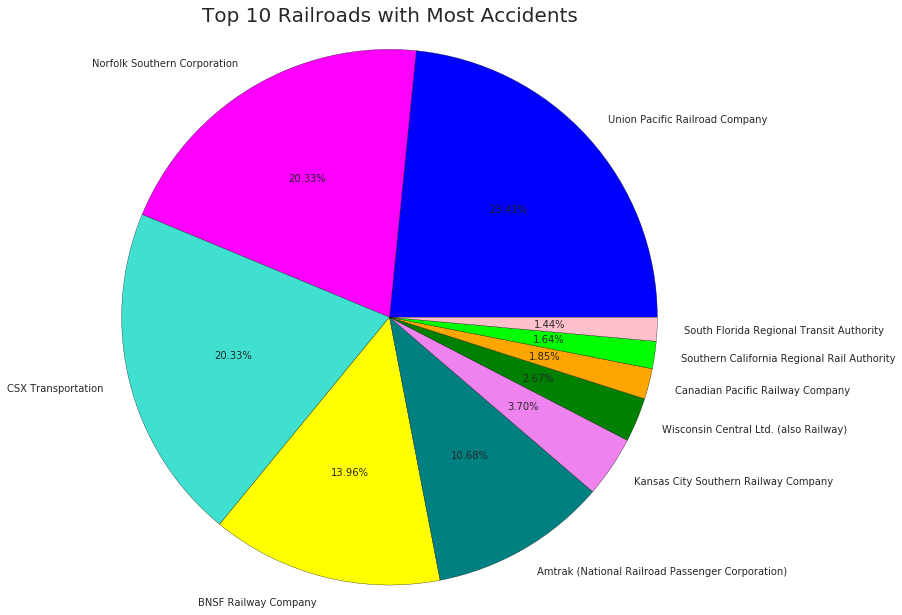

In [181]:
plt.axis('equal')
plt.title("Top 10 Railroads with Most Accidents", size=20, y=1.8)
plt.pie(
    accidents,
    labels=railroads,
    colors=['blue','magenta','turquoise','yellow','teal','violet','green','orange','lime','pink'],
    autopct="%1.2f%%",
    radius=3);

## Accidents by Daily Hours

In [195]:
time_accidents = sqlContext.sql("SELECT HOUR(Date) AS Hour, Count(*) AS Accident FROM test GROUP BY HOUR(Date)")

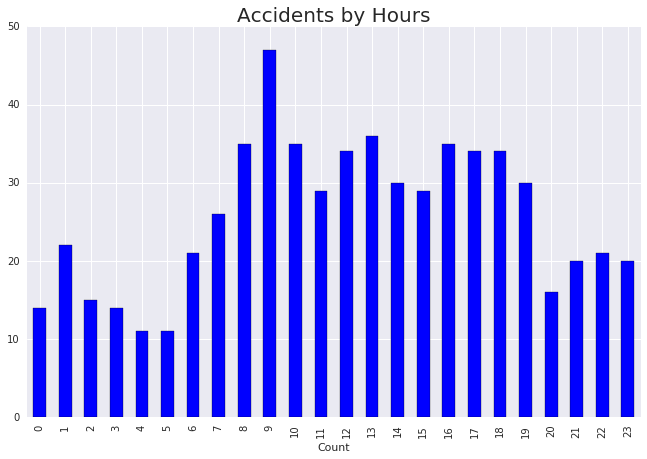

In [196]:
plottingdf = time_accidents.toPandas() 
plottingdf[['Accident']].plot(kind='bar', figsize=(11,7), legend=False) 
plt.title('Accidents by Daily Hours', size=20) 
plt.xlabel('Count')  
plt.show()